In [271]:
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets

import matplotlib.pyplot as plt

In [272]:
def func(x):
    return (np.sin(x)/x)-x/10

In [273]:
def data_generator(num_samples, lower, upper):
    
    x = np.linspace(lower, upper, num_samples)
    y = np.array([func(x) for x in x])
    
    data = np.stack((x, y))
    return data

In [274]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [275]:
data = data_generator(int(1e6), int(-0.5e3), int(0.5e3))

In [276]:
data = data.reshape(2, -1, 1, 100)

In [277]:
data.shape

(2, 10000, 1, 100)

In [278]:
data = data.transpose((1, 0, 2, 3))

In [279]:
data.shape

(10000, 2, 1, 100)

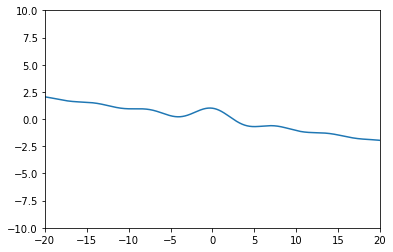

In [280]:
plt.plot(data[:, 0, :, :].reshape(-1, 1), data[:, 1, :, :].reshape(-1, 1))
plt.xlim((-20, 20))
plt.ylim((-10, 10))
plt.show()

In [281]:
class DotsDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(data)
    
    def __getitem__(self, idx):
        item = data[idx]
        if self.transform:
            item = self.transform(item)
        
        return item

In [296]:
data = torch.FloatTensor(data)

In [301]:
n_epochs = 300
batch_size = 64
lr = 0.0001

b1 = 0.5
b2 = 0.999
num_dots = 100
sample_interval = 25

In [302]:
std1 = (data[:, 0, :, :].reshape(-1, 1).max()-data[:, 0, :, :].reshape(-1, 1).min())/2
std2 = (data[:, 1, :, :].reshape(-1, 1).max()-data[:, 1, :, :].reshape(-1, 1).min())/2
mean1 = (data[:, 0, :, :].reshape(-1, 1).max()+data[:, 0, :, :].reshape(-1, 1).min())/2
mean2 = (data[:, 1, :, :].reshape(-1, 1).max()+data[:, 1, :, :].reshape(-1, 1).min())/2

In [303]:
dataset = DotsDataset(data, transform=transforms.Compose([transforms.Normalize([mean1, mean2], [std1, std2])]))

In [304]:
train_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [306]:
class UnNormalize():
    def __init__(self, means, stds):
        self.means = means
        self.stds = stds
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.means, self.stds):
            t.mul_(s).add_(m)
        
        return tensor

In [308]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True):
            layers=[nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, num_dots*2),
            nn.Tanh())
        
    def forward(self, x):
        dots = self.model(x)
        dots = dots.view(dots.size(0), 2, 1, num_dots)
        return dots

In [309]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(num_dots*2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        dots_flat = x.view(x.size(0), -1)
        val = self.model(dots_flat)
        return val

In [310]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (b1, b2))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

loss = torch.nn.BCELoss()

In [311]:
d_loss_history = []
g_loss_history = []
dots_history = []

In [312]:
def sample_dots(dots, means, stds):
    unnorm = UnNormalize(means, stds)
    idx = np.random.choice(len(dots))
    res = unnorm(dots[idx]).to('cpu').detach().numpy()
    return res

In [313]:
for epoch in range(n_epochs):
    
    for i, dots in enumerate(train_data):
        batch_size = dots.size(0)
        #Labels for real and fake data
        valid = torch.ones([batch_size, 1], requires_grad=False, dtype=torch.float32, device=device)
        fake = torch.zeros([batch_size, 1], requires_grad=False, dtype=torch.float32, device=device)
        
        real_dots = dots.type(torch.FloatTensor).to(device)
        
        #Train generator
        
        optimizer_g.zero_grad()
        
        z = torch.randn([batch_size, 100], device=device)
        
        gen_dots = generator(z)
        
        validity = discriminator(gen_dots)
        g_loss = loss(validity, valid)
        g_loss.backward()
        optimizer_g.step()
        
        #Train discriminator
        
        optimizer_d.zero_grad()
        
        real_pred = discriminator(real_dots)
        d_real_loss = loss(real_pred, valid)
        
        fake_pred = discriminator(gen_dots.detach())
        d_fake_loss = loss(fake_pred, fake)
        
        d_loss = (d_real_loss + d_fake_loss)/2
        d_loss.backward()
        optimizer_d.step()
        
        batches_done = epoch*len(train_data) + i
        if batches_done % sample_interval == 0:
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)
        if batches_done % len(train_data) == 0:
            dots_history.append(sample_dots(gen_dots, [mean1,mean2], [std1, std2]))
            print(f'Epoch {epoch}: g_loss={g_loss}, d_loss={d_loss}')

Epoch 0: g_loss=0.7138795852661133, d_loss=0.6955419778823853
Epoch 1: g_loss=0.7669394016265869, d_loss=0.6874167919158936
Epoch 2: g_loss=0.7649765610694885, d_loss=0.6873355507850647
Epoch 3: g_loss=0.6816396713256836, d_loss=0.6923230886459351
Epoch 4: g_loss=0.7186552882194519, d_loss=0.6939095258712769
Epoch 5: g_loss=0.7226535677909851, d_loss=0.6996320486068726
Epoch 6: g_loss=0.7428484559059143, d_loss=0.6919866800308228
Epoch 7: g_loss=0.6557193994522095, d_loss=0.6905393600463867
Epoch 8: g_loss=0.6682819128036499, d_loss=0.692414402961731
Epoch 9: g_loss=0.7147064208984375, d_loss=0.6924290657043457
Epoch 10: g_loss=0.6920810341835022, d_loss=0.691897988319397
Epoch 11: g_loss=0.6955858469009399, d_loss=0.6934531927108765
Epoch 12: g_loss=0.6674309968948364, d_loss=0.6886626482009888
Epoch 13: g_loss=0.7056947946548462, d_loss=0.6967622637748718
Epoch 14: g_loss=0.6996709108352661, d_loss=0.6902152299880981
Epoch 15: g_loss=0.6995013356208801, d_loss=0.6962908506393433
Epoc

Epoch 131: g_loss=0.6982688903808594, d_loss=0.6941102147102356
Epoch 132: g_loss=0.6906251311302185, d_loss=0.6938855051994324
Epoch 133: g_loss=0.6882330179214478, d_loss=0.6934857964515686
Epoch 134: g_loss=0.6947733163833618, d_loss=0.6941735744476318
Epoch 135: g_loss=0.6931710243225098, d_loss=0.6937493085861206
Epoch 136: g_loss=0.7049869894981384, d_loss=0.6911143064498901
Epoch 137: g_loss=0.6979935169219971, d_loss=0.6935899257659912
Epoch 138: g_loss=0.6923782825469971, d_loss=0.6931512355804443
Epoch 139: g_loss=0.7003952264785767, d_loss=0.6935958862304688
Epoch 140: g_loss=0.70753014087677, d_loss=0.691952645778656
Epoch 141: g_loss=0.6975785493850708, d_loss=0.6931148767471313
Epoch 142: g_loss=0.6988693475723267, d_loss=0.6928573846817017
Epoch 143: g_loss=0.6866323947906494, d_loss=0.6930403709411621
Epoch 144: g_loss=0.6915733218193054, d_loss=0.6927456855773926
Epoch 145: g_loss=0.6856624484062195, d_loss=0.6928750276565552
Epoch 146: g_loss=0.6765954494476318, d_los

Epoch 260: g_loss=0.6914995312690735, d_loss=0.6929174661636353
Epoch 261: g_loss=0.6932043433189392, d_loss=0.6934465169906616
Epoch 262: g_loss=0.692297101020813, d_loss=0.6918845176696777
Epoch 263: g_loss=0.6992058753967285, d_loss=0.6924596428871155
Epoch 264: g_loss=0.6915320158004761, d_loss=0.6925484538078308
Epoch 265: g_loss=0.6934210062026978, d_loss=0.6932845115661621
Epoch 266: g_loss=0.7075377702713013, d_loss=0.695155143737793
Epoch 267: g_loss=0.6974391937255859, d_loss=0.6926841139793396
Epoch 268: g_loss=0.6964563131332397, d_loss=0.6932606101036072
Epoch 269: g_loss=0.6902532577514648, d_loss=0.6940801739692688
Epoch 270: g_loss=0.6894271373748779, d_loss=0.6935161352157593
Epoch 271: g_loss=0.6923558712005615, d_loss=0.6937969326972961
Epoch 272: g_loss=0.6937086582183838, d_loss=0.6937190294265747
Epoch 273: g_loss=0.6919183731079102, d_loss=0.6930044889450073
Epoch 274: g_loss=0.6849260330200195, d_loss=0.6932388544082642
Epoch 275: g_loss=0.6922875642776489, d_lo

In [314]:
x = data[:, 0, :, :].reshape(-1, 1)
y = data[:, 1, :, :].reshape(-1, 1)

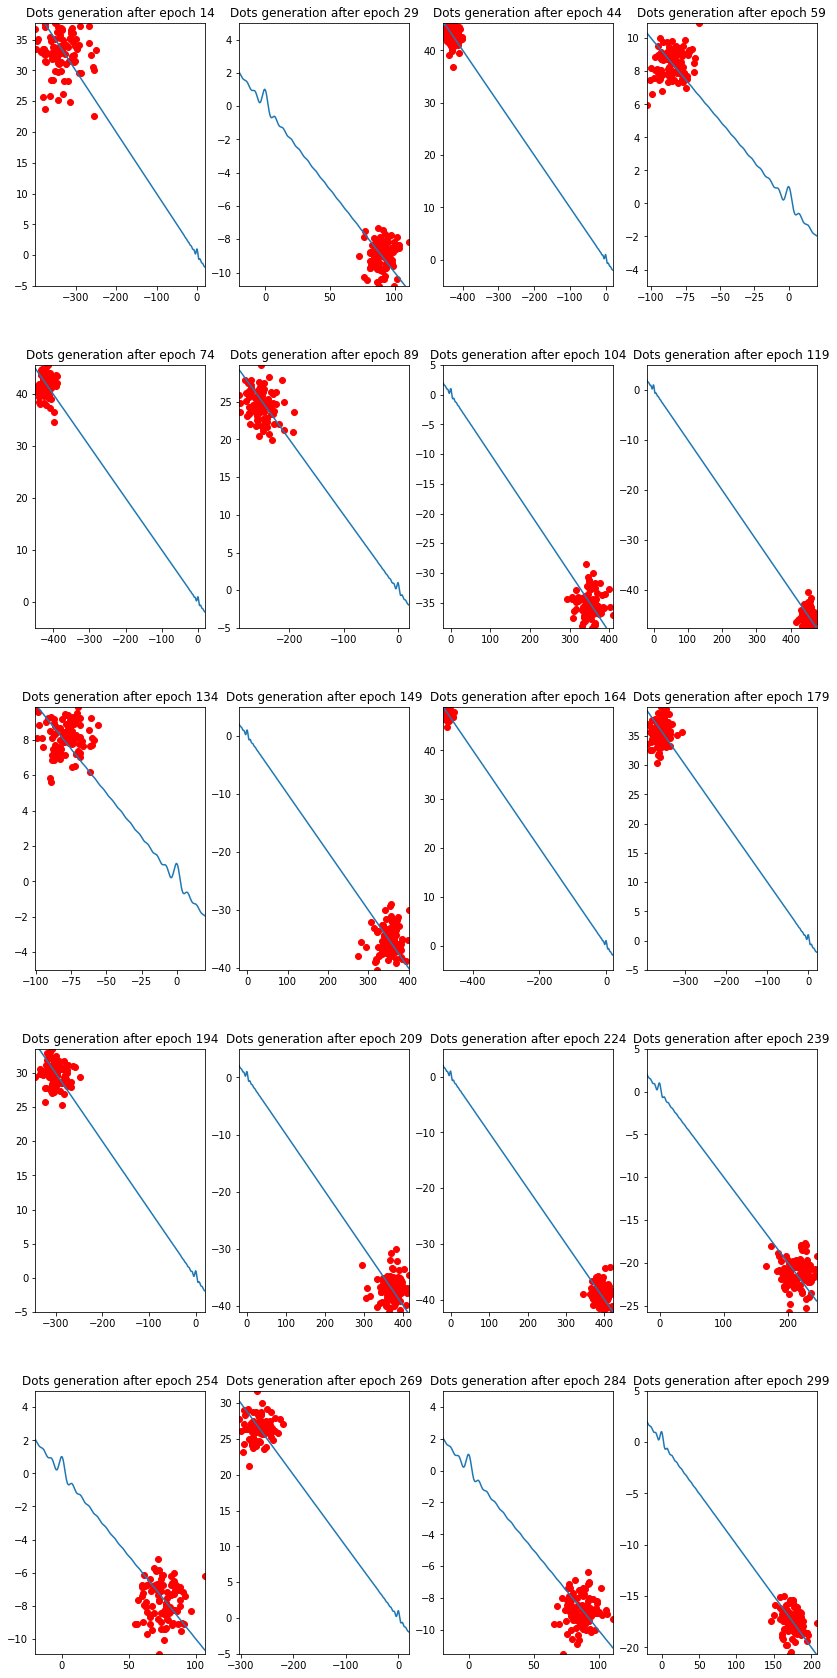

In [315]:
plt.figure(figsize=(14, 30))
for i, dot in enumerate(dots_history):
    if i % 15 == 14:
        plt.subplot(5,4, (i+14)//15)
        plt.plot(x, y)
        plt.scatter(dot[0].reshape(-1, 1), dot[1].reshape(-1, 1), color='red')
        plt.subplots_adjust(hspace=0.3)
        plt.title(f'Dots generation after epoch {i}')
        xlim = (min(-20, dot[0].min()), max(20, dot[0].max()))
        ylim = (min(-5, dot[1].min()), max(5, dot[1].max()))
        plt.xlim(xlim)
        plt.ylim(ylim)

plt.show()

В итоге за 300 эпох обучения нейросеть так и не научилась генерировать точки похожие на исходную функцию. У меня два варианта почему так получилось: 1)Плохо сгенерированные данные. Я не до конца уверен в том что я все правильно сделал на этом этапе, возможно стоило взять другой интервал точек. 2)Архитектура данной нейросети не подходит под решение этой задачи. Тут я бы хотел подсказку. Какая архитектура справилась бы с этой задачей?